In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import xarray as xr
import xcorr

In [2]:
plt.rcParams.update({'font.size': 9})

In [3]:
root = '../datasets'

## Systematic data selection

Open signal-to-noise ratio (S/N) coincidence trigger periods and plane wave sloweness results.

Time-lapse periods are S/N based only.

In [4]:
snr_ct = xr.open_dataset(f'{root}/snr_ct__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366.nc')
plane_wave = xr.open_dataset(f'{root}/beamform__IM.H03S[1-3]..EDH-IU.RAR.10.BHZ__2014121__2020366.nc')

Extract valid period and data

In [5]:
selected_times = plane_wave.time.where(
    (plane_wave.doa >= 241) & (plane_wave.doa <= 243) &
    (plane_wave.vel >= 1490) & (plane_wave.vel <= 1495) &
    (plane_wave.err < 0.002) & (snr_ct.ct >= 0),
    drop=True
)
sel_time1 = xr.DataArray(
    data=selected_times.time.values,
    dims=('time1',),
    coords={'time1': selected_times.time.values},
    attrs=selected_times.time.attrs,
)
sel_time2 = xr.DataArray(
    data=selected_times.time.values,
    dims=('time2',),
    coords={'time2': selected_times.time.values},
    attrs=selected_times.time.attrs,
)

In [6]:
selected_times

<xarray.DataArray 'time' (time: 2796)>
array(['2014-05-06T21:00:00.000000000', '2014-05-07T00:00:00.000000000',
       '2014-05-07T03:00:00.000000000', ...,
       '2020-11-24T00:00:00.000000000', '2020-11-24T03:00:00.000000000',
       '2020-11-24T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-05-06T21:00:00 ... 2020-11-24T06:00:00
Attributes:
    closed:          left
    window_length:   86400.0
    window_overlap:  0.875

In [7]:
def IQR(da, **kwargs):
    """Trimean
    """
    q = da.quantile([.25, .75], **kwargs)
    d = q.sel(quantile=.75) - q.sel(quantile=.25)
    return d.drop_vars('quantile', errors='ignore')


def trimean(da, **kwargs):
    """Trimean
    """
    q = da.quantile([.25, .50, .75], **kwargs)
    d = (.25*q.sel(quantile=.25) +
         .50*q.sel(quantile=.50) +
         .25*q.sel(quantile=.75))
    return d.drop_vars('quantile', errors='ignore')
    

def timelapse_qc(da, inequality='>', threshold=.5, fill=0):
    """Remove substandard times from the timelapse results
    """
    da = da.fillna(0.)
    t = trimean(da, dim='time2')
    N = da.pair.size

    mask = (eval(f"xcorr.signal.abs(t) {inequality} threshold")).sum(dim='pair') == N
    mask = mask.broadcast_like(da.isel(pair=0)) 

    mask.values = (mask.transpose('freq', 'time1', 'time2').values &
                   mask.transpose('freq', 'time2', 'time1').values)

    mask.name = 'mask'
    mask.attrs = {
        'long_name': f'Masked {da.attrs["long_name"]}',
        'standard_name': f'masked_{da.attrs["standard_name"]}',
        'units': '-',
        'threshold': threshold,
        'var': da.name,
    }

    return mask

## Load raw time-lapse results

In [8]:
ds = xr.open_dataset(
    f'{root}/lfs/timelapse__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366.nc',
    # drop_variables=['freq_bw', 'status'],  # avoids dimension increase by mask
)
ds.load()
ds.close()

### Extract eligible times (including beamforming and signal-to-noise ratio)
Raw time-lapse data contains signal-to-noise ratio based periods only.

In [9]:
timelapse_times = ds.time1.size

ds = ds.where((ds.time1 == sel_time1) & (ds.time2 == sel_time2), drop=True)
ds['freq_bw'] = ds.freq_bw.isel(time1=0, time2=0, drop=True)  # reset to original coordinates

print('selected {} out of {} times'.format(ds.time1.size, timelapse_times))

selected 2793 out of 3685 times


## Time-lapse QC

### Create mask

In [10]:
freq_lim = xr.DataArray(np.array([3., 6.])/4, coords=(ds.freq, ), dims=('freq',))

ds_mask_cc2 = timelapse_qc(ds.cc2, '>', .5)
ds_mask_delta_freq = timelapse_qc(ds.delta_freq, '<', freq_lim)

ds_mask = ds_mask_cc2 & ds_mask_delta_freq

### Filter time-lapse
Extract only valid times and store to a new netCDF file.

In [18]:
ds_filt = ds.where(ds_mask, drop=True)

ds_filt['freq_bw'] = ds_filt.freq_bw.isel(time1=0, time2=0, drop=True)

ds_filt.attrs['title'] = f"{ds.attrs['title']} [filtered]"
ds_filt.attrs['history'] = 'Filtered for eligible periods (signal-to-noise ratio coincidence trigger periods and plane wave sloweness characteristics)'

# ds_filt.xcorr.write(
#     f'{root}/lfs/timelapse__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366__filtered.nc',
#     variable_encoding=dict(zlib=True, complevel=9, shuffle=True),
# )

Write data as "../datasets/lfs/timelapse__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366__filtered.nc": Close. Hash. To temporary netcdf. Replace. Done.


### Distribution plots

<IPython.core.display.Javascript object>


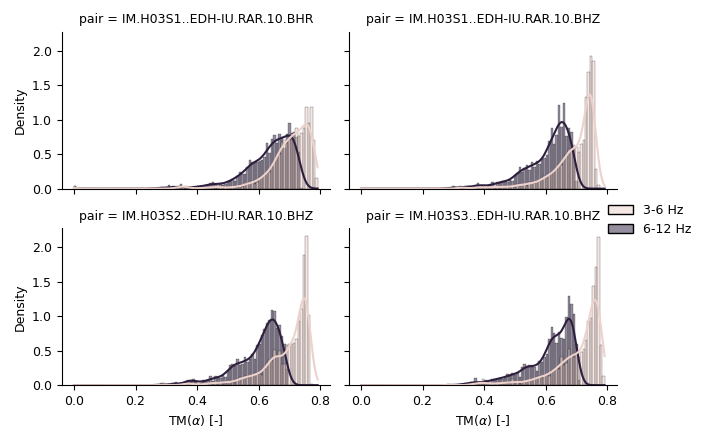

In [20]:
d = ds.cc2
qdf = trimean(d, dim='time2').to_dataframe()
g = sns.displot(data=qdf, x=d.name, col='pair', col_wrap=2, hue='freq', kde=True,
                stat="density", height=2.2, aspect=1.45)

g._legend.set_title(None)
for t, l in zip(g._legend.texts, ['3-6 Hz', '6-12 Hz']):
    t.set_text(l)

g.axes[-2].set_xlabel(r'TM$(\alpha)$ [-]')
g.axes[-1].set_xlabel(r'TM$(\alpha)$ [-]')

g.fig.savefig(f"figs/timelapse_{d.name}_trimean_displot.pdf")

/Users/psmets/miniconda3/envs/xcorr/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<IPython.core.display.Javascript object>


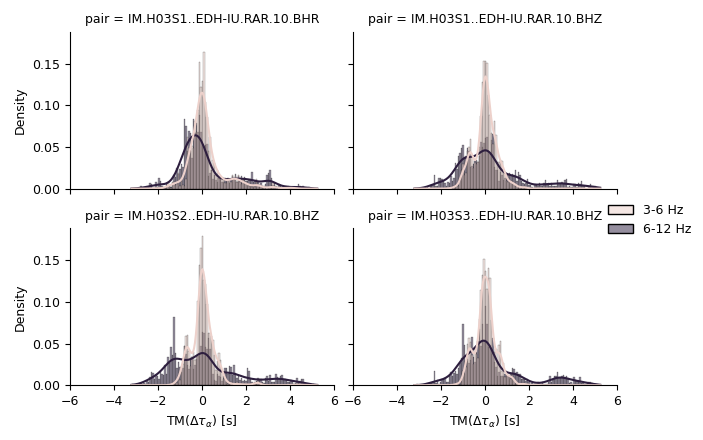

In [21]:
d = ds.delta_lag.where(ds_mask, drop=True)
qdf = trimean(d, dim='time2').to_dataframe().dropna()
xlim = [-6, 6]

g = sns.displot(data=qdf[(qdf[d.name] >= xlim[0]) & (qdf[d.name] <= xlim[1])],
                x=d.name, col='pair', col_wrap=2, hue='freq', kde=True,
                stat="density", height=2.2, aspect=1.45)

g._legend.set_title(None)
for t, l in zip(g._legend.texts, ['3-6 Hz', '6-12 Hz']):
    t.set_text(l)

g.axes[-2].set_xlabel(r'TM$(\Delta \tau_{{\alpha}})$ [{}]'.format(d.units))
g.axes[-1].set_xlabel(r'TM$(\Delta \tau_{{\alpha}})$ [{}]'.format(d.units))

for ax in g.axes:
    ax.set_xlim(xlim)

g.fig.savefig(f"figs/timelapse_{d.name}_trimean_displot.pdf")

/Users/psmets/miniconda3/envs/xcorr/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<IPython.core.display.Javascript object>


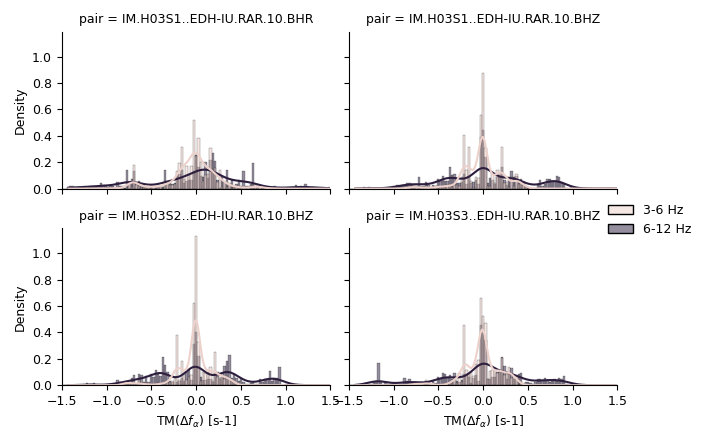

In [22]:
d = ds.delta_freq.where(ds_mask_delta_freq, drop=True)
qdf = trimean(d, dim='time2').to_dataframe()
xlim = [-1.5, 1.5]

g = sns.displot(data=qdf[(qdf[d.name] >= xlim[0]) & (qdf[d.name] <= xlim[1])],
                x=d.name, col='pair', col_wrap=2, hue='freq', kde=True,
                stat="density", binrange=(-1.5, 1.5), height=2.2, aspect=1.45)

g._legend.set_title(None)
for t, l in zip(g._legend.texts, ['3-6 Hz', '6-12 Hz']):
    t.set_text(l)

g.axes[-2].set_xlabel(r'TM$(\Delta f_{{\alpha}})$ [{}]'.format(d.units))
g.axes[-1].set_xlabel(r'TM$(\Delta f_{{\alpha}})$ [{}]'.format(d.units))


for ax in g.axes:
    ax.set_xlim(xlim)

g.fig.savefig(f"figs/timelapse_{d.name}_trimean_displot.pdf")

## Time-lapse plots

In [23]:
def add_year_to_index(ax, time, minor=True, center=True):
    """
    """
    t0 = pd.to_datetime(time[0].values) + DateOffset(month=1, day=1, normalize=True)
    t1 = pd.to_datetime(time[-1].values) + DateOffset(years=1, month=1, day=1, normalize=True)
    
    int_index = xr.DataArray(np.arange(time.size), dims=('time',), coords=(time,))
    t_major = int_index.sel(time=pd.date_range(t0, t1, freq='12MS'), method="nearest")
    
    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xticks(t_major.values[1:-1])
    ax_t.xaxis.set_major_formatter(ticker.NullFormatter())
    ax_t.set_xlabel(None)

    if minor:
        t_minor = int_index.sel(
            time=pd.date_range(t0 + DateOffset(month=7), t1 + DateOffset(years=-1, month=7), freq='12MS'),
            method="nearest"
        )
        if center:
            t_minor.values = t_major.values[:-1] + (t_major.diff('time', n=1)/2).astype(int).values
        
        ax_t.set_xticks(t_minor.values, minor=True)
        ax_t.set_xticklabels(t_minor.time.dt.strftime("%Y").values,
                             fontsize=6, fontstyle='italic', rotation=45, minor=True)
        
        for tick in ax_t.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')
            
    ax_r = ax.secondary_yaxis('right')
    ax_r.set_yticks(t_major.values[1:-1])
    ax_r.yaxis.set_major_formatter(ticker.NullFormatter())
    ax_r.set_ylabel(None)
            
    return (ax_t, ax_r)

selected 2109 out of 2793 times


<IPython.core.display.Javascript object>


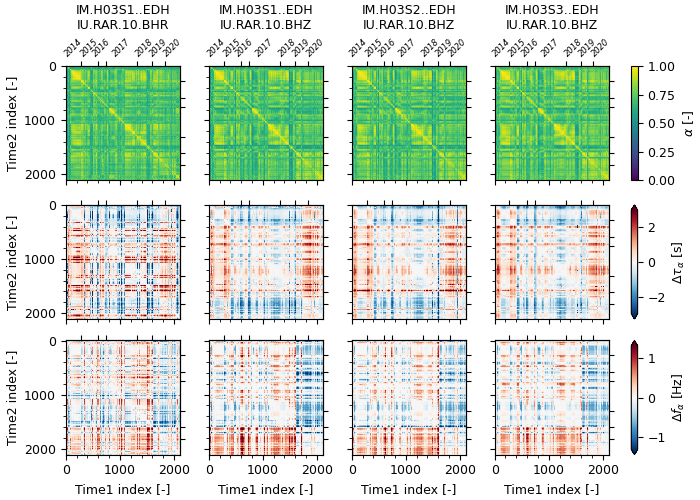

In [24]:
f = 0
filtered = True

freq = '6-12Hz' if f == 1 else '3-6Hz'
if filtered:
    ds2 = ds.isel(freq=f).where(ds_mask.isel(freq=f), drop=True)
    q = [.02, .98]
else:
    ds2 = ds.isel(freq=f)
    q = [.02, .98]

print('selected {} out of {} times'.format(ds2.time1.size, ds.time1.size))

fig = plt.figure(constrained_layout=True, figsize=(7, 5))

gs = GridSpec(nrows=3, ncols=5, figure=fig,
              height_ratios=(1, 1, 1,), width_ratios=(20, 20, 20, 20, 1))
gs.tight_layout(fig, pad=1.)

ax0 = []
for i in np.arange(0, 5):
    ax0.append(fig.add_subplot(gs[0, i]))

im0=[]
for p in np.arange(0, ds2.pair.size):
    im = ax0[p].imshow(X=ds2.cc2.isel(pair=p).values,
                       aspect=1, clim=[0, 1])
    im0.append(im)
    if p == 0:
        ax0[p].tick_params(labelbottom=False, labelleft=True)
        ax0[p].set_ylabel('Time2 index [-]')
    else:
        ax0[p].tick_params(labelbottom=False, labelleft=False)
    ax0[p].set_xlabel(None)
    ax0[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax0[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax0_t = add_year_to_index(ax0[p], ds2.time1, minor=True, center=True)
    ax0[p].set_title("\n".join(str(ds2.pair[p].values).split("-")), fontsize=9)

cb0 = plt.colorbar(im0[0], cax=ax0[-1], extend='neither')
cb0.ax.set_ylabel(r"$\alpha$" + f" [{ds2.cc2.units}]")


ax1 = []
for i in np.arange(0, 5):
    ax1.append(fig.add_subplot(gs[1, i]))

im1=[]
for p in np.arange(0, ds2.pair.size):
    im = ax1[p].imshow(X=ds2.delta_lag.isel(pair=p).values,
                       aspect=1, cmap='RdBu_r',
                       clim=np.array([-1, 1]) * np.abs(ds2.delta_lag.quantile(q)).max().values)
    im1.append(im)
    if p == 0:
        ax1[p].tick_params(labelbottom=False, labelleft=True)
        ax1[p].set_ylabel('Time2 index [-]')
    else:
        ax1[p].tick_params(labelbottom=False, labelleft=False)
    ax1[p].set_xlabel(None)
    ax1[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax1[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax1_t = add_year_to_index(ax1[p], ds2.time1, minor=False)

cb1 = plt.colorbar(im1[0], cax=ax1[-1], extend='both')
cb1.ax.set_ylabel(r"$\Delta \tau_{\alpha}$ [s]")


ax2 = []
for i in np.arange(0, 5):
    ax2.append(fig.add_subplot(gs[2, i]))

im2=[]
for p in np.arange(0, ds2.pair.size):
    im = ax2[p].imshow(X=ds2.delta_freq.isel(pair=p).values,
                       aspect=1, cmap='RdBu_r',
                       clim=np.array([-1, 1]) * np.abs(ds2.delta_freq.quantile(q)).max().values)
    im2.append(im)
    if p == 0:
        ax2[p].tick_params(labelbottom=True, labelleft=True)
        ax2[p].set_ylabel('Time2 index [-]')
    else:
        ax2[p].tick_params(labelbottom=True, labelleft=False)
    ax2[p].set_xlabel('Time1 index [-]')
    ax2[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax2[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax2_t = add_year_to_index(ax2[p], ds2.time1, minor=False)

cb2 = plt.colorbar(im2[0], cax=ax2[-1], extend='both')
cb2.ax.set_ylabel(r"$\Delta f_{\alpha}$ [Hz]")


plt.show()
plt.savefig(f"figs/timelapse_{freq}_{'filtered' if filtered else 'raw'}.pdf", dpi=300)